In [1]:
from astropy.io import fits 
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit

In [4]:
data = fits.open("/Users/natachaupra/Desktop/Project/Senior-Project/manga-8312-12701-LOGCUBE.fits.gz")

In [5]:
drpall = fits.open('/Users/natachaupra/Desktop/Project/Senior-Project/drpall-v2_4_3.fits')

In [6]:
wave = data['WAVE'].data

In [7]:
flux = np.transpose(data['FLUX'].data, axes=(2, 1, 0))

In [8]:
ivar = np.transpose(data["IVAR"].data, axes=(2, 1, 0))

### Choose the wavelength at O[III]

In [9]:
wave_index = np.where(wave <= 5007)

In [10]:
# We'll go with this wavelength for now
wave[wave_index[-1][-1]], wave_index[-1][-1]

(5006.10552528821, 1406)

## Try to do the loop with just one wavelength first

#### There must be a better idea than a double for loop I'm having rn =.=

In [11]:
lst = []
for i in range(76):
    for j in range(76):

        sigma = np.sqrt(1 / ivar[i][j][wave_index[-1][-1]]) if ivar[i][j][wave_index[-1][-1]] != 0 else 0.0
#         print(sigma)
#         print(sigma)
#         print(ivar[i][j][wave_index[-1][-1]])

        if flux[i][j][wave_index[-1][-1]] < sigma:
#             print('1',flux[i][j][wave_index[-1][-1]], sigma)
            lst.append(0)
        else:
#             print('0',flux[i][j][wave_index[-1][-1]],sigma)
            lst.append(flux[i][j][wave_index[-1][-1]])
lst = np.array(lst)
res = lst.sum()

### Get the range of wavelengths first 

wavelength chosen from H$\alpha$ region from the observed plot in the first notebook

In [12]:
wavelength_range = np.where((wave >= 4980) & (wave <= 5025))[0]

In [17]:
wavelength_range
len(wavelength_range)

39

In [26]:
flux_for_compare = []
ivar_for_compare = []

for i in wavelength_range:
    flux_for_compare.append(flux[:,:,i].flatten())
    ivar_for_compare.append(ivar[:,:,i].flatten())

flux_for_compare = np.array(flux_for_compare)
ivar_for_compare = np.array(ivar_for_compare)

# flux_for_compare, ivar_for_compare

## Now the loop!!!

Hell yeah this is fun. I'm excited !!


There is definitely a better way to do this than what I did down below, but yeah... 
(Take this for now. Let me at least get the idea of how to do this first)

In [27]:
result = []
sumres = []

for i in range(len(wavelength_range)):
    for j in range(5776):
        sigma = np.sqrt(1 / ivar_for_compare[i][j]) if ivar_for_compare[i][j] != 0 else 0
        
        if flux_for_compare[i][j] < sigma:
            result.append(0)
        else:
            result.append(flux_for_compare[i][j])
    sumres.append(sum(result))
    result = []


In [28]:
result_2sigma = []
sumres_2sigma = []

for i in range(len(wavelength_range)):
    for j in range(5776):
        sigma = np.sqrt(1 / ivar_for_compare[i][j]) if ivar_for_compare[i][j] != 0 else 0
        
        if flux_for_compare[i][j] < (2*sigma):
            result_2sigma.append(0)
        else:
            result_2sigma.append(flux_for_compare[i][j])
    sumres_2sigma.append(sum(result_2sigma))
    result_2sigma = []

In [29]:
result_3sigma = []
sumres_3sigma = []

for i in range(len(wavelength_range)):
    for j in range(5776):
        sigma = np.sqrt(1 / ivar_for_compare[i][j]) if ivar_for_compare[i][j] != 0 else 0
        
        if flux_for_compare[i][j] < (3*sigma):
            result_3sigma.append(0)
        else:
            result_3sigma.append(flux_for_compare[i][j])
    sumres_3sigma.append(sum(result_3sigma))
    result_3sigma = []

In [30]:
y = sumres
y2 = sumres_2sigma
y3 = sumres_3sigma
x = [wave[i] for i in wavelength_range]

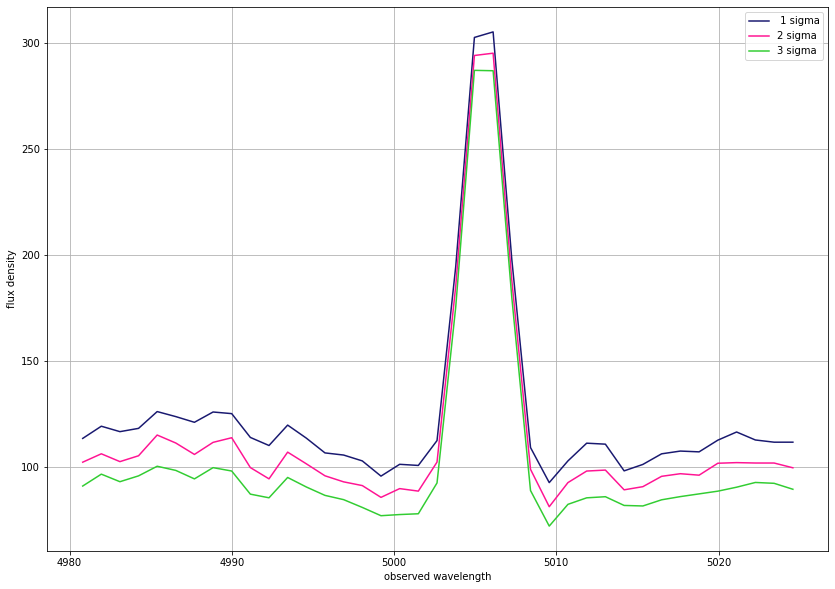

In [31]:
plt.figure(figsize = (14,10))
plt.grid()
plt.plot(x, y, color = 'midnightblue', label = ' 1 sigma') 
plt.plot(x, y2, color = 'deeppink', label = '2 sigma')
plt.plot(x, y3, color = 'limegreen', label = '3 sigma')
plt.xlabel('observed wavelength')
plt.ylabel('flux density')
plt.legend()

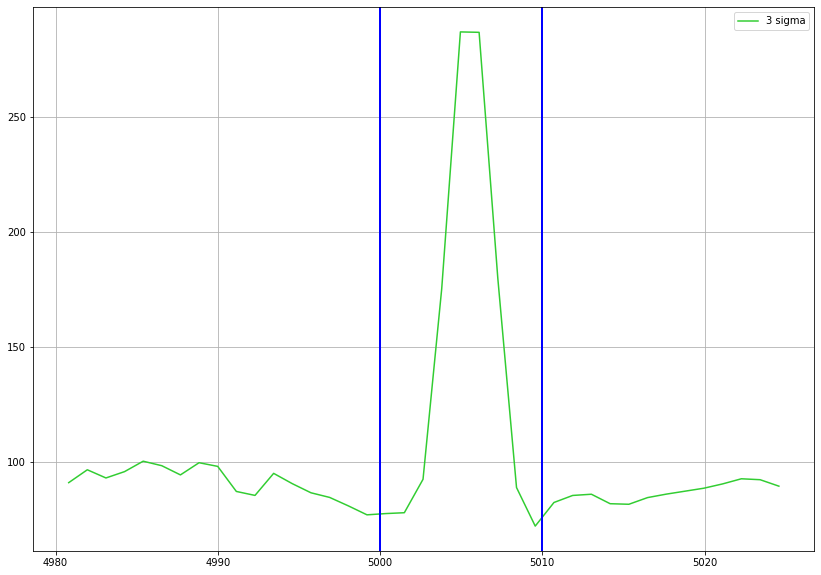

In [21]:
plt.figure(figsize = (14,10))
plt.grid()
plt.plot(x, y3, color = 'limegreen', label = '3 sigma')
plt.axvline(x = 5000, linewidth = 2, color = 'blue')
plt.axvline(x = 5010, linewidth = 2, color = 'blue')
plt.legend()

In [22]:
x = np.array(x)
sum_index = np.where(np.logical_and(x > 5000, x < 5011))

In [23]:
y3 = np.array(y3)
sum_y3 = np.sum(y3[sum_index])
print(sum_y3)

1421.305369099602


In [24]:
tbdata = drpall[1].data

In [25]:
zindex = np.where(tbdata['mangaid'] == '1-210866')

In [26]:
redshift = tbdata['nsa_z'][41]
redshift

0.0293829

<img src="Screenshots_/Distance_0.png">

$$ L = 4\pi d^2 \int^{\lambda_2}_{\lambda_1} f_\lambda d\lambda$$

In [27]:
# LD = luminosity distance
LD = 3.99595e26
luminosity = 4*np.pi*(LD**2)*sum_y3*(1e-17)

In [28]:
print(luminosity, 'erg/s')

2.8519200828707176e+40 erg/s


<img src="Screenshots_/TextFromThePaper.jpeg">

In [29]:
# With lambda_edd = 1
# This is M_BH / M_sun
M_BH = (3200 * luminosity) / (1 * 3.28 * 10**4)
print('log(M_BH / M_sun) = ', np.log(M_BH))
print('M_BH / M_sun = ', M_BH)
print('M_BH = ', M_BH*2*10**30)

log(M_BH / M_sun) =  90.82411849490302
M_BH / M_sun =  2.782361056459237e+39
M_BH =  5.564722112918474e+69


#### I'm pretty sure something went wrong somewhere...it doesn't feel right

#### I didn't check the object selection criteria of this paper very carefully, so I can't say that my answer is wrong just because the order of magnitude doesn't match/close with them

In [30]:
# Now what if I understood the text above wrong ? 
# Let's try again 

# Luminosity of the sun = 3.846 * 10**33
SL = 3.846 * 10**33
lumi = luminosity / SL
M_BH_= (3200 * lumi) / (1 * 3.28 * 10**4)
print('log(M_BH / M_sun) = ', np.log(M_BH_))
print('M_BH / M_sun = ', M_BH_)
print('M_BH = ', M_BH_*2*10**30)

log(M_BH / M_sun) =  13.491776778932927
M_BH / M_sun =  723442.8123918973
M_BH =  1.4468856247837946e+36


<img src="Screenshots_/TableData.jpeg">

In [31]:
dLambda = (wave[-1] - wave[0])/len(wave)
dLambda

1.4753910715072005

In [32]:
dlambda = np.array([])
for i in range(len(wave)-1):
    dlambda = np.append(dlambda, wave[i+1] - wave[i])
waveindex = [i for i in range(1,4563)]
len(dlambda), len(waveindex)

(4562, 4562)

4562

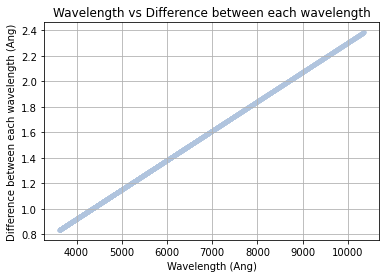

In [50]:
# plt.figure(figsize = (15,7))
plt.grid()
plt.title('Wavelength vs Difference between each wavelength')
# plt.xlim(2000,2100)
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Difference between each wavelength (Ang)')
plt.scatter(wave[0:-1], dlambda, marker=".", color = 'lightsteelblue')
# plt.scatter(waveindex, dlambda, marker =".")
plt.savefig('Screenshots_/dlambda1.png')

In [34]:
sum_index_new = np.where(np.logical_and(wave > 5000, wave< 5011))
sum_index_new

(array([1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410]),)

In [35]:
sum_y3_with_dlambda = np.sum(y3[sum_index]*dlambda[sum_index_new])
print(sum_y3_with_dlambda)

1638.3364034289273


In [36]:
# LD = luminosity distance
LD = 3.99595e26
luminosity_withdlambda = 4*np.pi*(LD**2)*sum_y3_with_dlambda*(1e-17)

print(luminosity_withdlambda, 'erg/s')
luminosity

3.287403673425304e+40 erg/s


2.8519200828707176e+40

In [37]:
# Now what if I understood the text above wrong ? 
# Let's try again 

# Luminosity of the sun = 3.846 * 10**33
SL = 3.846 * 10**33
lumi_withdlambda = luminosity_withdlambda / SL
M_BH_withdlambda= (3200 * lumi_withdlambda) / (1 * 3.28 * 10**4)
# print('log(M_BH / M_sun) = ', np.log(M_BH_withdlambda))
print('M_BH / M_sun = ', M_BH_withdlambda, 'solar masses')
# print('M_BH = ', M_BH_withdlambda*2*10**30)
M_BH_

M_BH / M_sun =  833911.3614208754 solar masses


723442.8123918973

In [39]:
wave[0], wave[-1]

(3621.5959848601933, 10353.805444147549)